# Logistic Regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import joblib

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, plot_roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, f1_score, plot_roc_curve, roc_auc_score, accuracy_score

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from imblearn.over_sampling import RandomOverSampler

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords


import thor

In [2]:
train = pd.read_csv('../data/total_train.csv')
test = pd.read_csv('../data/total_test.csv')

train.head()

,created_utc,title,class
0,1638807805,sheriff's office removes photo of santa fillin...,0
1,1636918297,this library lets you borrow people instead of...,0
2,1647961430,russian elements have infiltrated every elemen...,0
3,1511181800,only 4 drivers left alive go into final nascar...,1
4,1646768574,what happens in ukraine since 2015,0


In [3]:
X = train['title'].str.lower()
y = train['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.1, random_state=42)

--- 

# Logistic Regression: Base Model

The goal of a **logistic regression** model is to estimate the probability of a given data point beloning to a given class, e.g. $P( y = \text{ onion })$. Logistic Regression does this by reducing the problem down a previously solved problem: instead of doing regression on $P(y = 1)$ directly, we do a *linear regression* against the Log-Odds ratio:

<br>

$$\beta_0+\beta_1x_1+\ldots+\beta_nx_n = \log\left(\frac{P(y=1)}{1-P(y=1)}\right)$$

<br>

Like the Naive Bayes model before, we will need to encode the text-datum into a numeric form via Count Vectorizing, TF-IDF, and/or Sentiment Analysis.

### Base CountVectorizer Model

In [4]:
pipe1 = Pipeline([
            ('cvec', CountVectorizer()),
            ('logreg', LogisticRegression(max_iter=20_000))
        ])

# log1_params = {
#                 'cvec__ngram_range': [(1,2), (1,4), (1,5), (2,5)],
#                 'cvec__max_df': [0.3, 0.5],
#                 'cvec__stop_words':['english', None],
#                 'cvec__binary':[False, True],
#                 'logreg__C': [10, 1, 0.1]
#                 }

log1_params = {
                'cvec__ngram_range': [(1,2)],
                'cvec__max_df': [0.3],
                'cvec__stop_words':[None],
                'cvec__binary':[True],
                'logreg__C': [10]
                }

In [5]:
# log1 = GridSearchCV(pipe1, log1_params, cv=5, n_jobs=9)

# log1.fit(X_train, y_train)

# joblib.dump(log1, '../models/logreg1.pkl')

log1 = joblib.load('../models/logreg1.pkl')

In [6]:
log1.best_params_

{'cvec__binary': True,
 'cvec__max_df': 0.3,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': None,
 'logreg__C': 10}

In [7]:
log1.score(X_train, y_train), log1.score(X_test, y_test)

(0.9998893438087861, 0.9327772936636375)

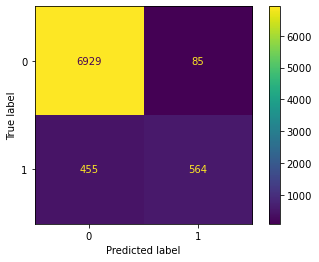

In [8]:
log1_preds = log1.predict(X_test)
cm = confusion_matrix(y_test, log1_preds)
cmd = ConfusionMatrixDisplay(cm)

cmd.from_predictions(y_test, log1_preds);

In [9]:
print(" ")
print("Recall: ", recall_score(y_test, log1_preds))
print(" ")
print("Precision: ", precision_score(y_test, log1_preds))
print(" ")
print("F1: ", f1_score(y_test, log1_preds))
print(" ")

 
Recall:  0.5534838076545633
 
Precision:  0.8690292758089369
 
F1:  0.6762589928057554
 


C:\Users\herma\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


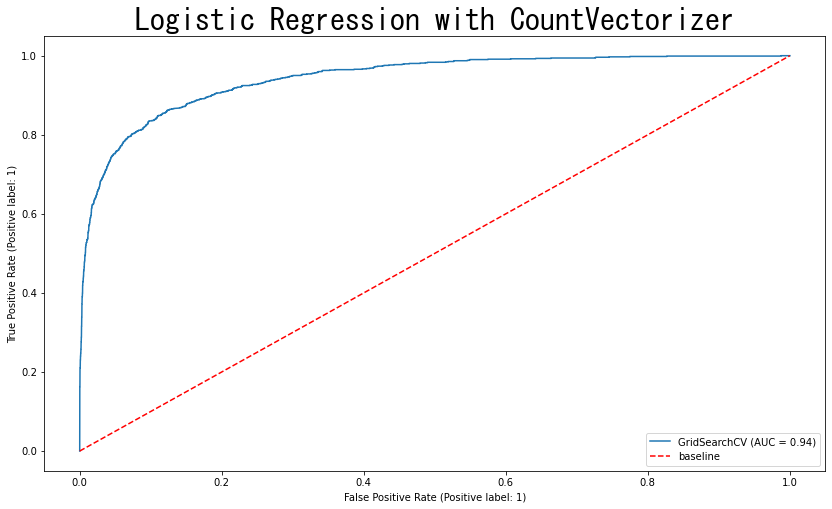

In [10]:
fig, ax = plt.subplots(1, figsize=(14,8));

plot_roc_curve(log1, X_test, y_test, ax=ax);
plt.plot([0,1],[0,1],linestyle='--', color='red', label='baseline');
plt.title('Logistic Regression with CountVectorizer', fontsize=30, font='ms gothic')
plt.legend(loc='lower right');

- All of the other metrics look outstanding. Even the ROC curve and AUC are as close to perfect as one could hope.

Since Logistic Regression predicts probabilities, we can play around with the classification threshold to tune the precision and recall.

In [11]:
def change_threshold(probs, threshold):
    pos_probs = pd.Series([p[1] for p in probs])
    return pos_probs.map(lambda p: 1 if p>=threshold else 0)

def verbose_eval(estimator, data, actual, threshold=0.5):
    preds = change_threshold(estimator.predict_proba(data), threshold)

    cmd.from_predictions(actual, preds);
    print(" ")
    print("Accuracy: ", accuracy_score(actual, preds))
    print(" ")
    print("Recall: ", recall_score(actual, preds))
    print(" ")
    print("Precision: ", precision_score(actual, preds))
    print(" ")
    print("F1: ", f1_score(actual, preds))
    print(" ")


 
Accuracy:  0.9348935640483007
 
Recall:  0.6437684003925417
 
Precision:  0.803921568627451
 
F1:  0.7149863760217983
 


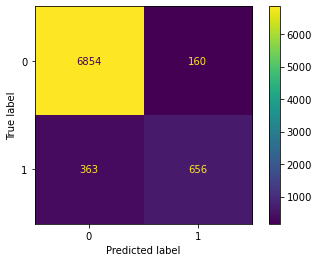

In [12]:
verbose_eval(log1, X_test, y_test, threshold=0.3)

In [13]:
# create a table with metrics for different decision boundaries/thresholds
scores = []

for threshold in range(20, 55, 5):
    new_preds = change_threshold(log1.predict_proba(X_test), threshold*0.01)
    col = {
            'threshold':threshold*0.01,
            'accuracy': accuracy_score(y_test, new_preds),
            'recall': recall_score(y_test, new_preds),
            'precision': precision_score(y_test, new_preds),
            'F1' : f1_score(y_test, new_preds)
          }
    scores.append(col)

thresh_scores = pd.DataFrame(scores)

In [14]:
thresh_scores

,threshold,accuracy,recall,precision,F1
0,0.20,0.932653,0.697743,0.753178,0.724401
1,0.25,0.933524,0.665358,0.778416,0.717460
2,0.30,0.934894,0.643768,0.803922,0.714986
3,0.35,0.936636,0.623160,0.835526,0.713884
4,0.40,0.934769,0.596663,0.843273,0.698851
5,0.45,0.933898,0.574092,0.857771,0.687831
6,0.50,0.932777,0.553484,0.869029,0.676259


### Over Sampling the Minority Class

In [15]:
ros = RandomOverSampler()

X_train_over, y_train_over = ros.fit_resample(np.array([[text] for text in X_train]),
                                              y_train)

X_train_over = pd.Series([text[0] for text in X_train_over])

In [16]:
X_train_over

0                           common signs of cervical cancer
1         cubana chief priest hires 7 rain makers to sen...
2         a geomagnetic storm may have effectively destr...
3         masten wanjala: mob beats kenyan child serial ...
4         astro, a founding member of the reggae group u...
                                ...                        
126253        nation hears voices encouraging it to buy gun
126254     genetic scientists develop sheep with goat brain
126255    nation's mothers describe how nice it would be...
126256          tips for airing grievances with your family
126257    life: the grim reality of income inequality: o...
Length: 126258, dtype: object

In [17]:
pipe2 = Pipeline([
            ('cvec', CountVectorizer()),
            ('logreg', LogisticRegression(max_iter=20_000))
        ])

log2_params = {
                'cvec__ngram_range': [(1,2)],
                'cvec__max_df': [0.3],
                'cvec__stop_words':[None],
                'cvec__binary':[True],
                'logreg__C': [10]
                }

In [18]:
# log2 = GridSearchCV(pipe2, log2_params, cv=5, n_jobs=9)

# log2.fit(X_train_over, y_train_over)

# joblib.dump(log2, '../models/log2.pkl')

log2 = joblib.load('../models/log2.pkl')

In [19]:
log2.score(X_train_over, y_train_over), log2.score(X_test, y_test)

(0.9998099130352136, 0.9342711315822233)

 
Accuracy:  0.9342711315822233
 
Recall:  0.6388616290480864
 
Precision:  0.8027127003699137
 
F1:  0.7114754098360657
 


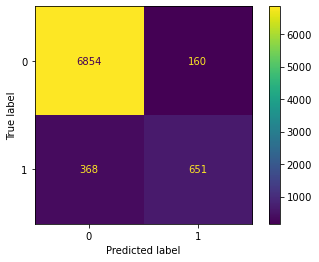

In [20]:
verbose_eval(log2, X_test, y_test)

 
Accuracy:  0.9355159965143782
 
Recall:  0.6094210009813543
 
Precision:  0.8380566801619433
 
F1:  0.7056818181818183
 


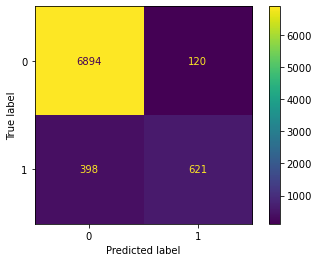

In [21]:
verbose_eval(log2, X_test, y_test, threshold=0.6)

---

# Logistic Regression: TF-IDF

In [22]:
pipe1 = Pipeline([
            ('tf', TfidfVectorizer()),
            ('logreg', LogisticRegression(max_iter=20_000))
        ])

log1_params = {
                'tf__ngram_range': [(1,2), (1,3), (1,4)],
                'tf__max_df': [0.3],
                'tf__stop_words':[None],
                'logreg__C': [10]
                }

In [23]:
# log3 = GridSearchCV(pipe1, log1_params, cv=5, n_jobs=5)

# log3.fit(X_train, y_train)

# joblib.dump(log3, '../models/log3.pkl')

log3 = joblib.load('../models/log3.pkl')

In [24]:
log3.score(X_train, y_train), log3.score(X_test, y_test)

(0.9977730441518203, 0.9337731856093614)

- Logistic Regression with TF-IDF resulted in a 93.4% accuracy. Things are getting better!

C:\Users\herma\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


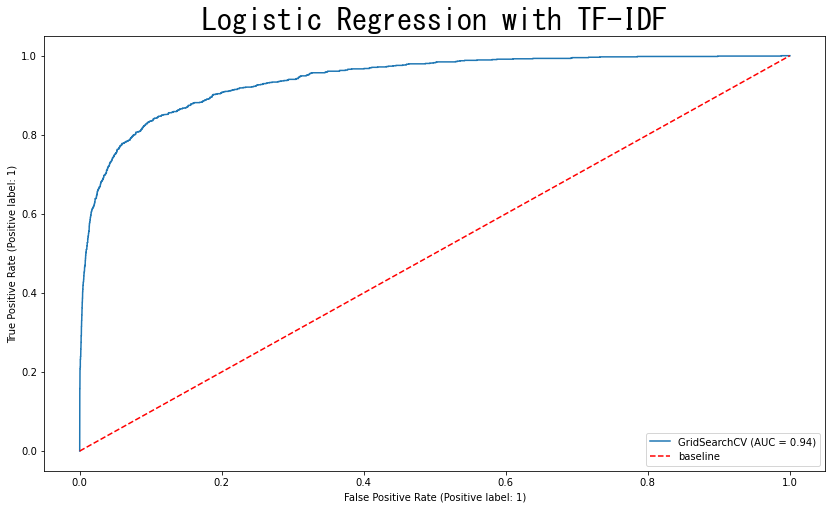

In [38]:
fig, ax = plt.subplots(1, figsize=(14,8));

plot_roc_curve(log2, X_test, y_test, ax=ax);
plt.plot([0,1],[0,1],linestyle='--', color='red', label='baseline');
plt.title('Logistic Regression with TF-IDF', fontsize=30, font='ms gothic')
plt.legend(loc='lower right');

plt.savefig('../images/log3-roc.png');

 
Accuracy:  0.9337731856093614
 
Recall:  0.577036310107949
 
Precision:  0.8534107402031931
 
F1:  0.6885245901639345
 


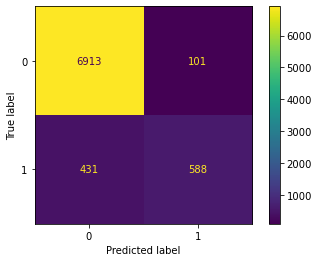

In [26]:
verbose_eval(log3, X_test, y_test)

 
Accuracy:  0.9355159965143782
 
Recall:  0.6310107948969578
 
Precision:  0.8191082802547771
 
F1:  0.7128603104212861
 


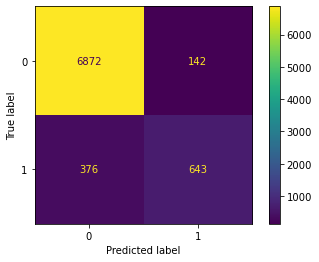

In [27]:
verbose_eval(log3, X_test, y_test, threshold=0.409)

- Overall, the TF-IDF encoding performs about the same as the Count Vectorizer encoding.

---

# Logistic Regression: Sentiment Analysis

In [28]:
Xsia_train = thor.vaderize(X_train)
Xsia_test = thor.vaderize(X_test)

In [29]:
train_sia = pd.concat([Xsia_train, y_train.reset_index(drop=True)], axis=1)

In [30]:
train_sia.head()

,neg,neu,pos,compound,text,class
0,0.524,0.476,0.000,-0.6597,common signs of cervical cancer,0
1,0.000,1.000,0.000,0.0000,cubana chief priest hires 7 rain makers to sen...,0
2,0.227,0.567,0.206,-0.0772,a geomagnetic storm may have effectively destr...,0
3,0.477,0.523,0.000,-0.8481,masten wanjala: mob beats kenyan child serial ...,0
4,0.231,0.769,0.000,-0.5574,"astro, a founding member of the reggae group u...",0


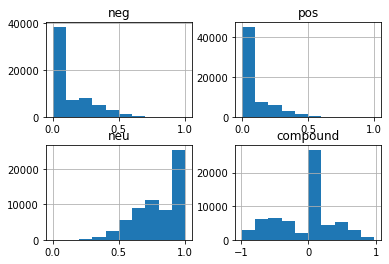

In [31]:
# distribtution of polarity scores for class 0 (r/news)
train_sia[ train_sia['class']==0 ].hist(column=['neg','pos', 'neu','compound']);

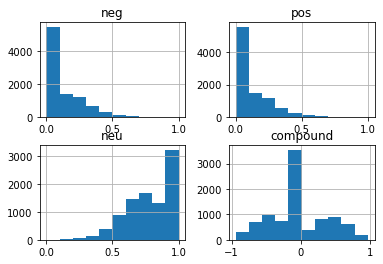

In [32]:
# distribution of polarity scores for class 1 (r/theonion)
train_sia[ train_sia['class']==1 ].hist(column=['neg','pos', 'neu','compound']);

- The distributions in polarity scores looke almost identical, so we suspect Sentiment Analysis will not yield great results here.

In [33]:
train_sia[ train_sia['class']==1 ]

,neg,neu,pos,compound,text,class
12,0.333,0.667,0.000,-0.5423,caitlyn jenner sues bruce jenner over sexual h...,1
16,0.000,1.000,0.000,0.0000,so-called christian has erection,1
34,0.000,1.000,0.000,0.0000,"they said what?!: find out what emma stone, da...",1
49,0.000,1.000,0.000,0.0000,the deep themes of our nations mental health i...,1
53,0.339,0.558,0.104,-0.7096,jim jordan spends hearing demanding michael co...,1
...,...,...,...,...,...,...
72266,0.756,0.244,0.000,-0.9081,victim in fatal accident tragically not glenn ...,1
72277,0.496,0.504,0.000,-0.7096,police repeatedly shoot tim cook after mistaki...,1
72278,0.048,0.693,0.260,0.7096,trump touts success of singapore summit after ...,1
72281,0.231,0.769,0.000,-0.5574,show-and-tell marred by every child bringing a...,1


In [34]:
log4 = LogisticRegression(n_jobs=8)

log4.fit(Xsia_train.drop(columns=['text','compound']), y_train)

LogisticRegression(n_jobs=8)

In [35]:
log4.score(Xsia_train.drop(columns=['text','compound']), y_train), log4.score(Xsia_test.drop(columns=['text','compound']), y_test)

(0.8732018368927742, 0.8731482634134197)

 
Accuracy:  0.8732018368927742
 
Recall:  0.0
 
Precision:  0.0
 
F1:  0.0
 


C:\Users\herma\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


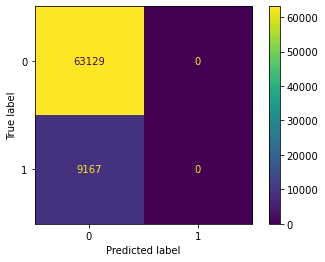

In [36]:
verbose_eval(log4, Xsia_train.drop(columns=['text','compound']), y_train)

C:\Users\herma\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


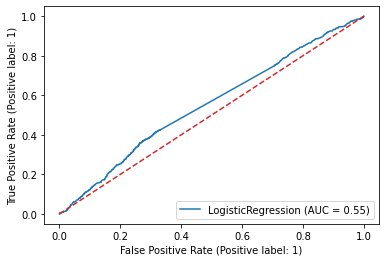

In [37]:
plot_roc_curve(log4, Xsia_test.drop(columns=['text','compound']), y_test);
plt.plot([0,1],[0,1],linestyle='--', color='tab:red');

- Unsurprisingly, Sentiment Analysis did not lead to good results. We suspect that the concept of "satire" and "humor" and "parody" are just not inherently well-handled by Sentiment Analysis. (This deficiency in SIA was also confirmed by Heather Robbins from General Assembly).